In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats
import sys
import os
from pykeen.datasets.base import PathDataset
from pykeen.predict import predict_target, two_group_g2p_ranking_test
from scipy.stats import kstest
import pickle
from scipy.stats import mannwhitneyu, kruskal, pearsonr

sys.path.append(os.path.abspath('../src/'))

from utils import get_predictions_tail

## Load Data

In [2]:
TEST_PATH: str =  '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
TRAIN_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt'
VALID_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/valid.txt'

class STRINGHPO(PathDataset):
    def __init__(self, **kwargs):
        super().__init__(
            training_path=TRAIN_PATH,
            testing_path=TEST_PATH,
            validation_path=VALID_PATH,
            **kwargs,
        )

data = STRINGHPO()
data.summarize() 

# these are used to know if a triple is in the training, testing or validation set
train_triples = set([ str(x) for x in data.training.triples])
test_triples = set([ str(x) for x in data.testing.triples])
valid_triples = set([ str(x) for x in data.validation.triples])

You're trying to map triples with 537 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 535 from 30992 triples were filtered out
Reconstructing all label-based triples. This is expensive and rarely needed.


STRINGHPO (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    36245       3              6029790
Testing     36245       3                30457
Validation  36245       3               135927
Total       -           -              6196174
Head        Relation    tail
----------  ----------  ----------
HP:0000001  HPO2HPO     HP:0000005
HP:0000001  HPO2HPO     HP:0000118
HP:0000001  HPO2HPO     HP:0012823
HP:0000001  HPO2HPO     HP:0031797
HP:0000001  HPO2HPO     HP:0032223



Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [3]:
# Load the STRING_HPO network edges
df: pd.DataFrame = pd.read_csv(
    "../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt", sep="\t"
)
df.columns = ["source", "relation", "target"]

# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

## Load Model

In [4]:
# Load the pretrained model
model = torch.load(
    "../PyKeenOut/stringhpo_rotate_trail_1.2/trained_model.pkl",
    map_location=torch.device("cpu"),
)

## Sex Specific Rankings
What is the relationship between rank for a gene to be connected to a specific HPO term for only gene-phenotype pairs that are not connected at time t but are in t+1?

### For HPO terms that I manually curated as being sex specific

In [5]:
# get a set of genes
genes = set()
for line in open(TRAIN_PATH,'r'):
    row = line.strip().split('\t')
    if 'STRING:' in row[0]:
        genes.add(row[0])
    if 'STRING:' in row[2]:
        genes.add(row[2])
genes = list(genes)
# sort the genes
genes.sort()
print('# genes', len(genes))

female_terms = []
male_terms = []
for line in open('../SexCurationResults/file_1686685843.3780549.csv','r'):
    row = line.strip().split(',')
    if row[2] == 'm':
        male_terms.append(row[1])
    elif row[2] == 'f':
        female_terms.append(row[1])
    elif row[2] == 'o':
        pass
    else: 
        print('error', row)

print('Number of female terms:',len(female_terms))
print('Number of male terms:',len(male_terms))
print(genes[:10])

def split_sort_return_str(line):
    # split a line on tabs, sort the elements and return a string
    return '\t'.join(sorted(line.split('\t')))

# genes 21659
error ['', 'hpo', 'label']
error ['0', 'hpo', 'label']
Number of female terms: 288
Number of male terms: 192
['STRING:1', 'STRING:1-minute', 'STRING:1st', 'STRING:2', 'STRING:2nd', 'STRING:3rd', 'STRING:4th', 'STRING:5', 'STRING:5-oxoprolinase', 'STRING:5th']


### Get the list of genes connect to these HPO terms in t+1 but not in t
The training, validation and test sets used for the model were 2019,2020 and 2021 respectively. So we will consider t=2021 for this experiment to be super sure the t+1 edges have never been seen of measured again by the model.

In [6]:
def get_percentile_dict(hpos,relation,data,model,degs,train_triples,test_triples,valid_triples):
    hpo2genes_percentiles = {}
    for i,term in enumerate(hpos):
        if i % 20 == 0:
            print(round(i/len(hpos),2) * 100, '% done')
        try:
            predictions_df: pd.DataFrame = get_predictions_tail(
                term,
                'STRING2HPO',
                data,
                model,
                degs,
                train_triples=train_triples,
                test_triples=test_triples,
                valid_triples=valid_triples
            )
        except KeyError:
            print('key error', term)
            continue
        # remove 'HP:' terms from the predictions
        predictions_df = predictions_df[~predictions_df['tail_label'].str.contains('HP:')]
        predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
        # sort the predictions by the tail_label
        predictions_df = predictions_df.sort_values(by=['tail_label'])
        hpo2genes_percentiles[term] = predictions_df['percentile'].tolist()
    return hpo2genes_percentiles

def get_group_specific_percentiles(all_genes,x_percentiles,new_edges_tp1):
    specific_phenotypes2genes = {}
    for term in x_percentiles.keys():
        specific_phenotypes2genes[term] = []
        tmp_seen_genes = set()
        for edge_line in new_edges_tp1:
            # if the term is in the edge and the edge is g2p
            if term in edge_line and 'STRING:' in edge_line and 'HP:' in edge_line:
                edge = edge_line.strip().split('\t')
                # get the gene
                gene = [x for x in edge if 'STRING:' in x][0]
                if gene in tmp_seen_genes:
                    continue
                tmp_seen_genes.add(gene)
                if gene not in all_genes:
                    print('gene not in genes', gene)
                    continue
                gi = all_genes.index(gene)
                specific_phenotypes2genes[term].append(x_percentiles[term][gi])
    return specific_phenotypes2genes

def plot_degs_vs_percentiles(flattened_percentiles,label_a_degs,label_b_degs,prefix, label_a, label_b):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(label_a_degs,flattened_percentiles[label_a])
    axes[0].set_title(label_a)
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Percentile')
    axes[1].scatter(label_b_degs,flattened_percentiles[label_b])
    axes[1].set_title(label_b)
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Percentile')

    # log scale the x axis
    axes[0].set_xscale('log')
    axes[1].set_xscale('log')
    

    # remove top and right borders
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # match the y axis range
    max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
    axes[0].set_ylim([0,max_y])
    axes[1].set_ylim([0,max_y])
    # match x axis range
    max_x = max([max(axes[0].get_xlim()),max(axes[1].get_xlim())])
    axes[0].set_xlim([0,max_x])
    axes[1].set_xlim([0,max_x])

    plt.tight_layout()
    plt.savefig('../Figures/{}_{}_v_{}_g2p_rankings_deg.png'.format(prefix,label_a,label_b))



def two_group_g2p_ranking_test(prefix,hpos_a,hpos_b,label_a,label_b,data,model,degs,train_triples,test_triples,valid_triples,all_genes,relation):
    # get the t edge list, this was the validation set for 2019
    t_el = '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
    # load t_el as a set of string
    t_el_set = set([split_sort_return_str(line) for line in open(t_el,'r')])
    # ge the t+1 edge list, this was the validation set for 2020
    tp1_el = '../ELs_for_Rotate/String_HPO_2020.all_hpo/test.txt'
    # load tp1_el as a set of string
    tp1_el_set = set([split_sort_return_str(line) for line in open(tp1_el,'r')])
    new_edges_tp1 = tp1_el_set.difference(t_el_set)

    a_percentiles = get_percentile_dict(hpos_a,relation,data,model,degs,train_triples,test_triples,valid_triples)
    b_percentiles = get_percentile_dict(hpos_b,relation,data,model,degs,train_triples,test_triples,valid_triples)
    print('a_percentiles',len(a_percentiles))
    print('b_percentiles',len(b_percentiles))
    a_specific_percentiles = get_group_specific_percentiles(all_genes,a_percentiles,new_edges_tp1)
    b_specific_percentiles = get_group_specific_percentiles(all_genes,b_percentiles,new_edges_tp1)
    print('a_specific_percentiles',len(a_specific_percentiles))
    print('b_specific_percentiles',len(b_specific_percentiles))

    flattened_percentiles = {label_a:[],label_b:[]}

    label_a_degs = []
    label_b_degs = []

    for key in a_specific_percentiles.keys():
        flattened_percentiles[label_a] += list(a_specific_percentiles[key])
        if key in degs:
            d = [degs[key]] * len(a_specific_percentiles[key])
        else:
            d = [0] * len(a_specific_percentiles[key])
        label_a_degs += d


    for key in b_specific_percentiles.keys():
        flattened_percentiles[label_b] += list(b_specific_percentiles[key])
        if key in degs:
            d = [degs[key]] * len(b_specific_percentiles[key])
        else:
            d = [0] * len(b_specific_percentiles[key])
        label_b_degs += d
    
    if len(flattened_percentiles[label_a]) == 0 or len(flattened_percentiles[label_b]) == 0:
        print('one of the groups has new g2p edges added in year t+1')
        return 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # make bins 0 -  1 in increments of .1
    bins = np.arange(0, 1.1, 0.1)
    axes[0].hist(flattened_percentiles[label_a],bins=bins)
    axes[0].set_title(label_a)
    axes[0].set_xlabel('Percentile')
    axes[0].set_ylabel('Frequency')
    axes[1].hist(flattened_percentiles[label_b],bins=bins)
    axes[1].set_title(label_b)
    axes[1].set_xlabel('Percentile')
    axes[1].set_ylabel('Frequency')

    # remove top and right borders
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # match the y axis range
    max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
    axes[0].set_ylim([0,max_y])
    axes[1].set_ylim([0,max_y])


    plt.tight_layout()
    plt.savefig('../Figures/{}_{}_v_{}_g2p_rankings_hist.png'.format(prefix,label_a,label_b))
    plt.show()

    plot_degs_vs_percentiles(flattened_percentiles,label_a_degs, label_b_degs,prefix,label_a,label_b)

    # Kruskal is a non-parametric test intended for multiple groups
    print('flattened_percentiles[label_a]',len(flattened_percentiles[label_a]))
    print('flattened_percentiles[label_b]',len(flattened_percentiles[label_b]))
    flattened_percentiles[label_a].sort()
    flattened_percentiles[label_b].sort()
    print(flattened_percentiles[label_a])
    print(flattened_percentiles[label_b])
    U1, p = kruskal(flattened_percentiles[label_a], flattened_percentiles[label_b])
    print('p-value', p)

    # what percent of the genes are in the top 10%?
    print('Percent of genes in top 10%')
    print(label_a, len([x for x in flattened_percentiles[label_a] if x > 0.8])/len(flattened_percentiles[label_a]))
    print(label_b, len([x for x in flattened_percentiles[label_b] if x > 0.8])/len(flattened_percentiles[label_b]))

    U1_8, p_8 = kruskal([x for x in flattened_percentiles[label_a] if x >= .8], [x for x in flattened_percentiles[label_b] if x >= .8])
    print('p-value for scores > 0.8', p_8)

    return p
    

female HP:0001561 186
female HP:0001562 104
male HP:0000027 91
male HP:0000054 198
male HP:0000047 258
male HP:0000028 581


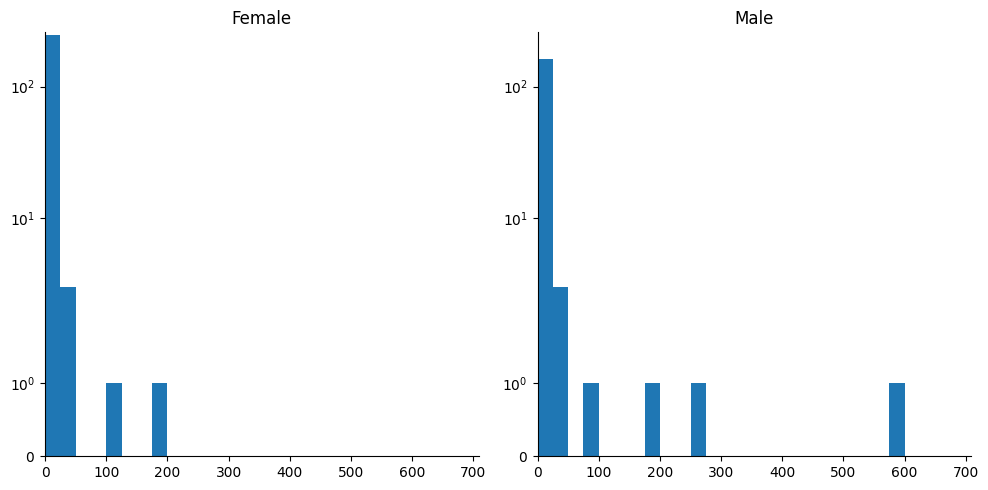

In [7]:
# Degree distributions of male vs female terms
# get the degree of each term
female_degree = [ degs[x] for x in female_terms if x in degs]
male_degree = [ degs[x] for x in male_terms if x in degs]

# create a set of bins 0 - 600 every 25
bins = np.arange(0, 700, 25)

# plot the degree distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(female_degree, bins=bins)
axes[0].set_title('Female')
#remove top and right borders
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].hist(male_degree, bins=bins)
axes[1].set_title('Male')
#remove top and right borders
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# match the y axis range
max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
axes[0].set_ylim([0,max_y])
axes[1].set_ylim([0,max_y])

# match the x axis range
max_x = max([max(axes[0].get_xlim()),max(axes[1].get_xlim())])
axes[0].set_xlim([0,max_x])
axes[1].set_xlim([0,max_x])

# log scale y
axes[0].set_yscale('symlog')
axes[1].set_yscale('symlog')

# print the names of all nodes with degree > 80 in the female and male sets
for x in female_terms:
    if x in degs and degs[x] > 80:
        print('female',x, degs[x])
for x in male_terms:
    if x in degs and degs[x] > 80:
        print('male',x, degs[x])

plt.tight_layout()
plt.savefig('../Figures/manually_curated_female_v_male_specific_degree_distributions.png')
plt.show()

0.0 % done
key error HP:0034558
key error HP:0034344
key error HP:0034268
key error HP:0034263
key error HP:0034264
key error HP:0034266
key error HP:0034269
7.000000000000001 % done
14.000000000000002 % done
key error HP:0033084
key error HP:0033085
key error HP:0033086
key error HP:0033840
key error HP:0033338
key error HP:0034719
21.0 % done
key error HP:0034503
key error HP:0034571
28.000000000000004 % done
key error HP:0034709
35.0 % done
key error HP:0034326
42.0 % done
key error HP:4000153
key error HP:0033020
49.0 % done
key error HP:0033588
56.00000000000001 % done
62.0 % done
key error HP:0034492
key error HP:0034546
69.0 % done
key error HP:0025715
key error HP:0025719
76.0 % done
key error HP:0025664
key error HP:0025665
key error HP:0025666
key error HP:0033712
key error HP:0025675
83.0 % done
key error HP:0032571
90.0 % done
key error HP:0034756
key error HP:0034757
key error HP:0034758
key error HP:0034778
key error HP:4000173
key error HP:0033587
key error HP:0033758
97

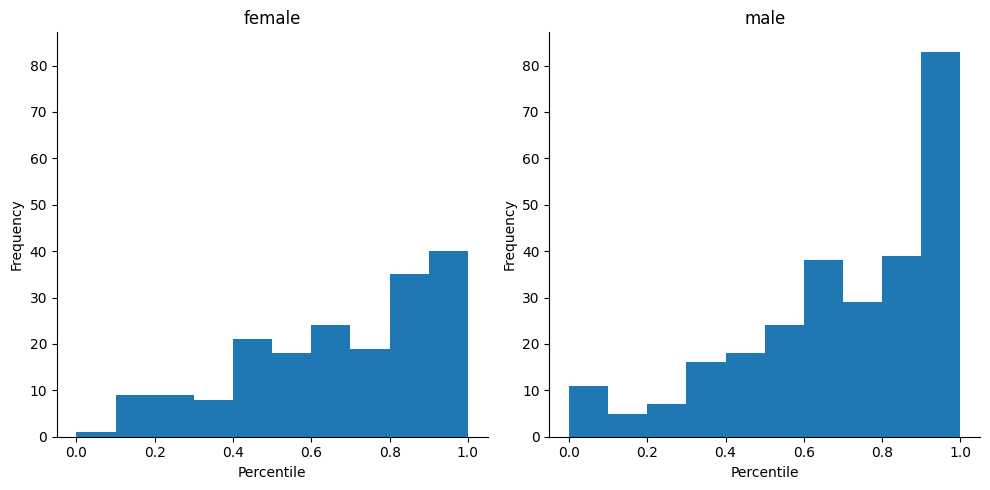

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_36335/2994200331.py:77: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0,max_x])
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_36335/2994200331.py:78: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0,max_x])


flattened_percentiles[label_a] 184
flattened_percentiles[label_b] 270
[0.09894270280253012, 0.10619142157994367, 0.13080012927651322, 0.13315480862459023, 0.1451128860981578, 0.14534373701463596, 0.156747772288656, 0.15919479200332426, 0.1607645782353756, 0.19035966572787294, 0.2025947643012143, 0.20970497252874093, 0.22327900641765547, 0.24774920356433816, 0.25158132877787526, 0.25513643289163856, 0.2820074795696939, 0.29096449512904565, 0.297243640057251, 0.3025532111362482, 0.30296874278590885, 0.3250380904012189, 0.3380580820905859, 0.3420748880373055, 0.36262061960385983, 0.3630823214368161, 0.3897686873816889, 0.4134078212290503, 0.4175169675423611, 0.41982547670714254, 0.4290595133662681, 0.434276744078674, 0.45232928574726444, 0.4566231127937578, 0.46387183157117134, 0.4651184265201533, 0.466642042568909, 0.4707973590655155, 0.47707650399372087, 0.4777690567431553, 0.49171245209843484, 0.49226649429798236, 0.4933284085137818, 0.49660649152777137, 0.4976222355602752, 0.498868830

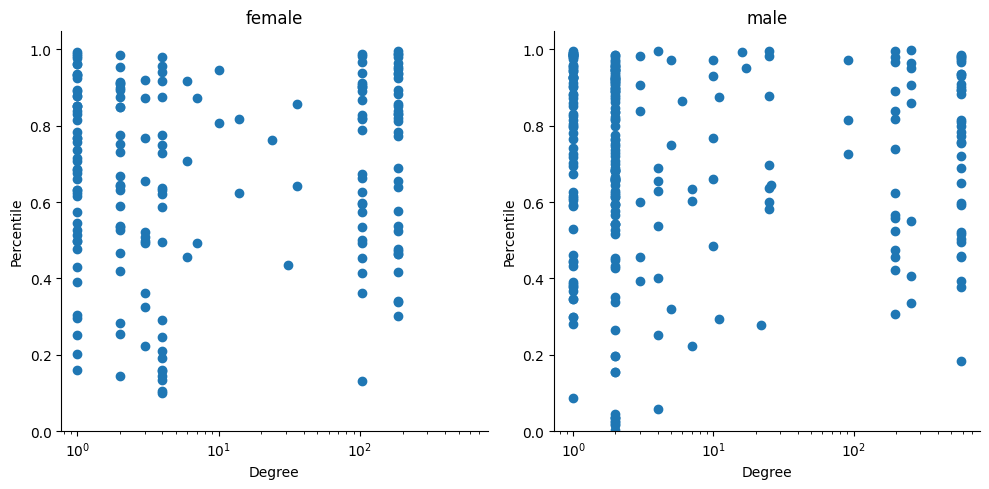

In [8]:
manual_p = two_group_g2p_ranking_test(prefix='manually_curated',
                            hpos_a=female_terms,
                            hpos_b=male_terms,
                            label_a='female',
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2HPO')

## HPO Terms annotated as female or male
In the HPO annotation file there is a column to indicate if a relationship is sex specific. The HPO terms associated here are not necessarily inherently sex specific, but the link between them as a disease in OMIM has been labeled as such.

In [9]:
female_annotated_hpos: list = [ line.strip() for line in open('../Resources/just_female_hpos.txt')]
print('# female terms', len(female_annotated_hpos))
male_annotated_hpos: list = [ line.strip() for line in open('../Resources/just_male_hpos.txt')]
print('# female terms', len(male_annotated_hpos))

# female terms 87
# female terms 169


0.0 % done
key error HP:0033085
23.0 % done
46.0 % done
69.0 % done
92.0 % done
0.0 % done
key error HP:0033195
key error HP:0033725
12.0 % done
key error HP:0034049
24.0 % done
key error HP:0033606
36.0 % done
47.0 % done
key error HP:0033425
59.0 % done
71.0 % done
83.0 % done
95.0 % done
a_percentiles 86
b_percentiles 164
gene not in genes STRING:HRURF
gene not in genes STRING:MARS1
gene not in genes STRING:H1-4
gene not in genes STRING:AARS1
gene not in genes STRING:MARS1
gene not in genes STRING:AARS1
gene not in genes STRING:MARS1
gene not in genes STRING:ADPRS
gene not in genes STRING:G6PC1
gene not in genes STRING:EPRS1
gene not in genes STRING:AARS1
gene not in genes STRING:DYNLT2B
gene not in genes STRING:MARS1
gene not in genes STRING:MARS1
gene not in genes STRING:YARS1
gene not in genes STRING:CCDC32
gene not in genes STRING:DYNLT2B
gene not in genes STRING:H1-4
gene not in genes STRING:VARS1
gene not in genes STRING:NARS1
gene not in genes STRING:HRURF
gene not in genes S

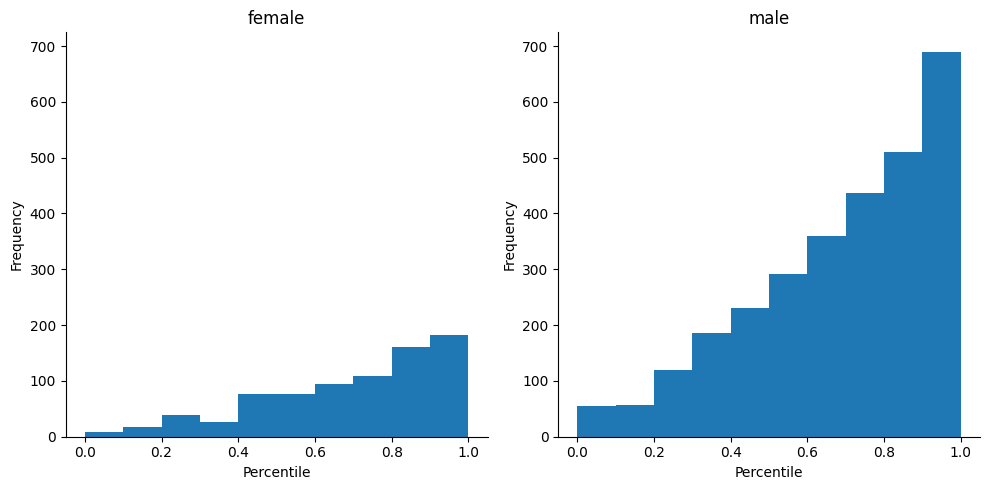

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_36335/2994200331.py:77: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0,max_x])
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_36335/2994200331.py:78: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0,max_x])


flattened_percentiles[label_a] 790
flattened_percentiles[label_b] 2936
[0.0031395724641026827, 0.04141465441617803, 0.04547763054619327, 0.04912507502654786, 0.052449328223833046, 0.07581144097142066, 0.07802760976961079, 0.0942333441063761, 0.09672653400434, 0.11099312064268896, 0.12096588023454453, 0.14132693106791633, 0.1430813980331502, 0.14534373701463596, 0.14552841774781847, 0.15536266678978716, 0.15919479200332426, 0.16118010988503625, 0.1727688258922388, 0.17747818458839282, 0.18251073456761624, 0.1829262662172769, 0.1884666882127522, 0.19326838727549747, 0.1939609400249319, 0.19973221293688537, 0.212798374809548, 0.21838496698831894, 0.2191698601043446, 0.21935454083752712, 0.21944688120411837, 0.21958539175400527, 0.22327900641765547, 0.2378226141557782, 0.24253197285193223, 0.24437878018375733, 0.2446558012835311, 0.24636409806546933, 0.25024239346230204, 0.2505194145620758, 0.25158132877787526, 0.25472090124197794, 0.25513643289163856, 0.2560136663742555, 0.256567708573803

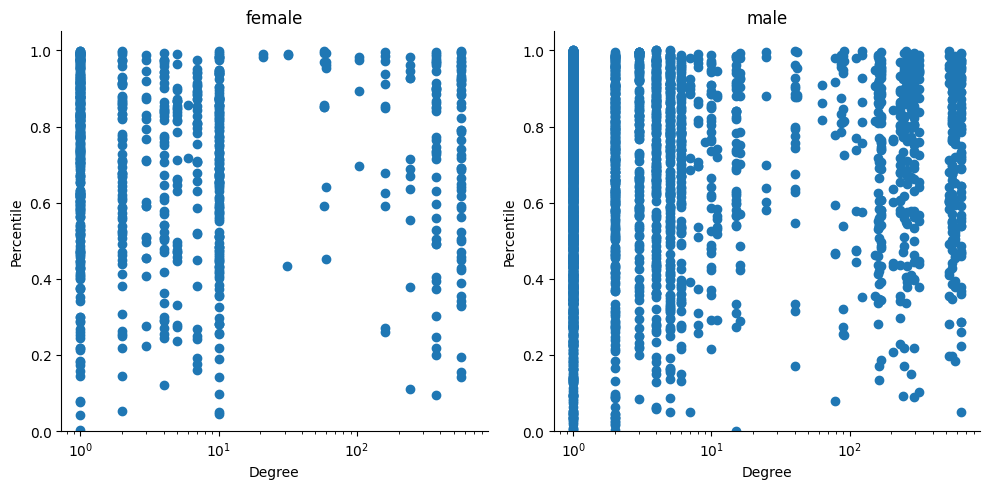

In [10]:
annotated_p = two_group_g2p_ranking_test(prefix='annotated',
                            hpos_a=female_annotated_hpos,
                            hpos_b=male_annotated_hpos,
                            label_a='female',
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2HPO')

## Sex Differentially Expressed Genes

In [11]:
# Load the data
xls = pd.ExcelFile('../Resources/aba3066-table-s2.xlsx')

gene_tissue_counts_female = {}
gene_tissue_counts_male = {}
t2g2s = {'tissue':[],'gene':[],'sex':[]}
tissue_2_gene_by_sex = {}
for sheet_name in xls.sheet_names[2:]:
    xdf = xls.parse(sheet_name)
    for i,row in xdf.iterrows():
        g = row['HUGO_gene_id']
        is_female = row['MASH beta'] > 0
        if is_female:
            if g not in gene_tissue_counts_female:
                gene_tissue_counts_female[g] = 0
            gene_tissue_counts_female[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('female')
        else:
            if g not in gene_tissue_counts_male:
                gene_tissue_counts_male[g] = 0
            gene_tissue_counts_male[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('male')

# build a DF for these that are differentially expressed and with greater expression in females
genes_female = gene_tissue_counts_female.keys()
data_female = {'gene':genes_female,'tissue_count':[gene_tissue_counts_female[g] for g in genes_female]}
df_female = pd.DataFrame(data_female)
df_female['tissue_count'].max()
print('females',df_female[df_female['tissue_count'] == df_female['tissue_count'].max()])
df_female = df_female[df_female['tissue_count'] < 45]
print('females',df_female.shape)

# build a DF for these that are differentially expressed and with greater expression in males
genes_male = gene_tissue_counts_male.keys()
data_male = {'gene':genes_male,'tissue_count':[gene_tissue_counts_male[g] for g in genes_male]}
df_male = pd.DataFrame(data_male)
df_male['tissue_count'].max()
print('males',df_male[df_male['tissue_count'] == df_male['tissue_count'].max()])
df_male = df_male[df_male['tissue_count'] < 45]
print('males',df_male.shape)

# add prefix 'STRING:' to all genes
df_female['gene'] = [ 'STRING:'+x for x in df_female['gene']]
df_male['gene'] = [ 'STRING:'+x for x in df_male['gene']]

genes_female = list(df_female['gene'])
genes_male = list(df_male['gene'])


females    gene  tissue_count
27  NaN           739
females (2433, 2)
males   gene  tissue_count
3  NaN          1090
males (2364, 2)


In [12]:
print(len(genes_female))
print(len(genes_male))
print(type(genes_female))
print(df_female)

2433
2364
<class 'list'>
               gene  tissue_count
0       STRING:XIST            44
1      STRING:KDM6A            44
2      STRING:KDM5C            44
3     STRING:EIF1AX            44
4      STRING:RPS4X            44
...             ...           ...
2429   STRING:WDR89             1
2430  STRING:SECTM1             1
2431   STRING:ZNF91             1
2432  STRING:TMEM71             1
2433   STRING:PRDM5             1

[2433 rows x 2 columns]


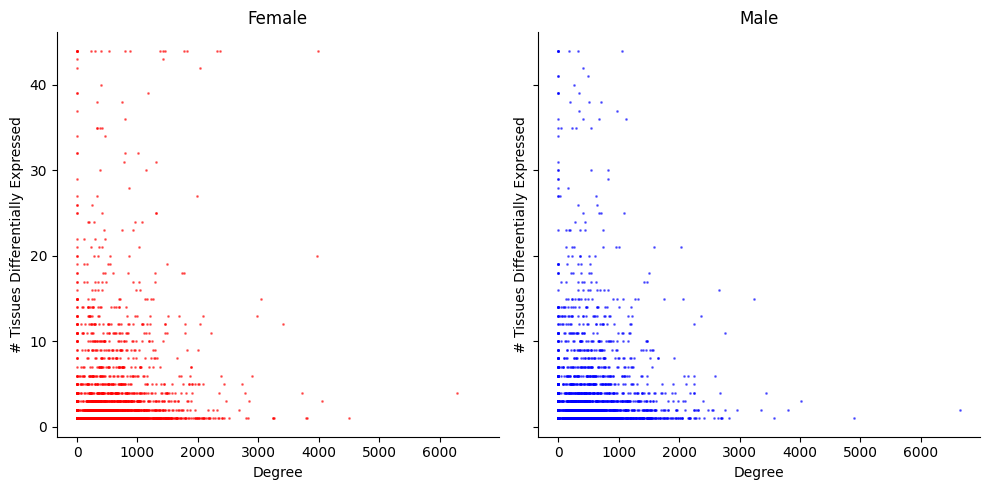

Female Pearson's R= PearsonRResult(statistic=0.016189431381413794, pvalue=0.42475854283030806)
Male Pearson's R= PearsonRResult(statistic=-0.08771738082546912, pvalue=1.9469982046331922e-05)


In [15]:
# plot degree vs # tissues differentially expressed in seporated by sex

df_female['degree'] = [ degs[x] if x in degs else -1 for x in df_female['gene']]
df_male['degree'] = [ degs[x] if x in degs else -1 for x in df_male['gene']]

fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True, sharex=True)

ax[0].scatter(df_female['degree'],df_female['tissue_count'],label='female',color='red',s=1, alpha=0.5)
ax[0].set_title('Female')

ax[1].scatter(df_male['degree'],df_male['tissue_count'],label='male',color='blue',s=1, alpha=0.5)
ax[1].set_title('Male')

ax[0].set_xlabel('Degree')
ax[0].set_ylabel('# Tissues Differentially Expressed')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('# Tissues Differentially Expressed')

# remove top and right borders
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../Figures/diff_expr_degree_vs_tissues.png',dpi=300)
plt.show()

# pearson correlation between degree and # tissues differentially expressed
print('Female Pearson\'s R=',pearsonr(df_female['degree'],df_female['tissue_count']))
print('Male Pearson\'s R=',pearsonr(df_male['degree'],df_male['tissue_count']))

In [16]:
annotated_p = two_group_g2p_ranking_test(prefix='differential_expression',
                            hpos_a=genes_female,
                            hpos_b=genes_male,
                            label_a='female',
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')

0.0 % done
key error STRING:PUDP
key error STRING:JPX
key error STRING:CA5BP1
1.0 % done
key error STRING:DIPK2B
key error STRING:INE1
key error STRING:RPS4XP11
key error STRING:EIF1AXP1
2.0 % done
key error STRING:LINC00993
key error STRING:PRSS30P
key error STRING:RPS4XP2
key error STRING:TSPEAR-AS2
key error STRING:TPTEP1
2.0 % done
key error STRING:TSPEAR-AS1
key error STRING:RPS4XP6
key error STRING:LINC02575
3.0 % done
key error STRING:EIF2S3B
4.0 % done
key error STRING:DLX6-AS1
key error STRING:SERPINA3
5.0 % done
key error STRING:BMS1P10
key error STRING:RPS4XP13
key error STRING:ZNF667-AS1
6.0 % done
key error STRING:PLPP1
key error STRING:LINC02298
7.000000000000001 % done
key error STRING:RPS4XP3


### Is there bias against sex differentially expressed genes as a whole?
Not male vs female, but differentially expressed vs not?

In [ ]:
# get a list of all sexually differentially expressed genes
all_dif_exp_genes = genes_female + genes_male

annotated_p = two_group_g2p_ranking_test(prefix='differential_expression',
                            hpos_a=all_dif_exp_genes,
                            hpos_b=genes,
                            label_a='sex_specific',
                            label_b='all_genes',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')


### Differentially expressed in ANY genes

### Degree vs number of tissue differentially expressed in

### Differentially expressed in all genes

## Other groups
Olfactory, Recessive, Dominant, Haploinsufficient

These groups come from The mutational constraint spectrum quantified from variation in 141,456 humans
Karczewski et al 2020

https://www.nature.com/articles/s41586-020-2308-7#Sec12

In [ ]:
# load the TSV

gene_group_df = pd.read_csv('../supplementary_dataset_13_gene_lists.tsv',sep='\t')

for group in gene_group_df['gene_list'].unique:
    print(group)
    group_genes = [ 'STRING:' + gene for x in gene_group_df[gene_group_df['gene_list'] == group]['gene']]
    print('Number genes in group:',len(group_genes))
    
    # VS female
    annotated_p = two_group_g2p_ranking_test(prefix=group,
                            hpos_a=group_genes,
                            hpos_b=genes_female,
                            label_a=group,
                            label_b='female',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')

    # VS male
    annotated_p = two_group_g2p_ranking_test(prefix=group,
                            hpos_a=group_genes,
                            hpos_b=genes_male,
                            label_a=group,
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')

## Cancer Genes
The follow list of cancer related genes was taken from here
https://www.facingourrisk.org/info/hereditary-cancer-and-genetic-testing/genes-by-cancer-types

In [ ]:
# Cancer genes
# this list is ta
cancer_genes = []
#Breast cancer in women	
cancer_genes = cancer_genes + ['ATM', 'BARD1', 'BRCA1', 'BRCA2', 'BRIP1', 'CHEK2',  'CDH1', 'NF1', 'PALB2', 'PTEN', 'RAD51C', 'RAD51D', 'STK11', 'TP53']

# Breast cancer in men	
cancer_genes = cancer_genes + ['BRCA1', 'BRCA2', 'CHEK2', 'PALB2']

# Colorectal cancer	
cancer_genes = cancer_genes + ['APC', 'EPCAM', 'MLH1', 'MSH2', 'MSH6', 'PMS2', 'CHEK2', 'PTEN', 'STK11', 'TP53', 'MUTYH']

# Endometrial cancer	
cancer_genes = cancer_genes + ['BRCA1', 'EPCAM', 'MLH1', 'MSH2', 'MSH6', 'PMS2', 'PTEN', 'STK11']

# Fallopian tube, ovarian, primary peritoneal cancer	
cancer_genes = cancer_genes + ['ATM', 'BRCA1', 'BRCA2', 'BRIP1', 'EPCAM', 'MLH1',  'MSH2',  'MSH6', 'NBN', 'PALB2', 'RAD51C', 'RAD51D']

# Gastric cancer	
cancer_genes = cancer_genes + ['APC', 'CDH1', 'STK11', 'EPCAM', 'MLH1', 'MSH2', 'MSH6', 'PMS2']

# Melanoma	
cancer_genes = cancer_genes + ['BAP1', 'BRCA2' 'CDK4', 'CDKN2A', 'PTEN', 'TP53']

# Pancreatic cancer	
cancer_genes = cancer_genes + ['ATM', 'BRCA1', 'BRCA2', 'CDKN2A', 'EPCAM', 'MLH1',  'MSH2', 'MSH6', 'PALB2', 'STK11', 'TP53']

# Prostate cancer	
cancer_genes = cancer_genes + ['ATM', 'BRCA1', 'BRCA2', 'CHEK2', 'HOXB13', 'PALB2', 'EPCAM', 'MLH1', 'MSH2', 'MSH6',  'PMS2']

cancer_genes = list(set(cancer_genes))
cancer_genes.sort()

print('Number of uniq cancer genes:', len(cancer_genes))

# add prefix "STRING:" to all genes
cancer_genes = [ 'STRING:' + x for x in cancer_genes]

In [ ]:
# VS female
annotated_p = two_group_g2p_ranking_test(prefix='cancer',
                        hpos_a=cancer_genes,
                        hpos_b=genes_female,
                        label_a='cancer',
                        label_b='female',
                        data=data,
                        model=model,
                        degs=degs,
                        train_triples=train_triples,
                        test_triples=test_triples,
                        valid_triples=valid_triples,
                        all_genes=genes,
                        relation='STRING2STRING')

# VS male
annotated_p = two_group_g2p_ranking_test(prefix='cancer',
                        hpos_a=cancer_genes,
                        hpos_b=genes_male,
                        label_a='cancer',
                        label_b='male',
                        data=data,
                        model=model,
                        degs=degs,
                        train_triples=train_triples,
                        test_triples=test_triples,
                        valid_triples=valid_triples,
                        all_genes=genes,
                        relation='STRING2STRING')

## Ancestral population specific bais
Using allele frequency (AF) information about ancestral population from gnomAD, find all ancestral specific variants (ASV) - variants where only one population has a non-zero AF. Then find genes that have only ASVs from the same population. These are the genes we are testing here.

In [ ]:
# european_genes = ['AL645608.2','MIR4417','MIR4421','GYG1P3','?','MIR4424','RP11-504P24.5','MIR4431','RNU1-32P','MIR548AE1','AC079610.1','MIR4792','THOC7','MIR548AE2','AC008387.1','?','MIR3660','MIR4460','AC011431.2','CTB-57H20.1','CTD-2532K18.1','MIR3925','MIR4464','MIR548AJ1','?','MIR4465','OR7E38P','?','LINC00476','MIR3927','MIR4675','ANXA8','snoU13','MIR378C','RP11-750H9.5','MIR4493','RP11-366L20.4','MIR5700','MIR4472-2','INTS6-AS1','MIR5007','PRR20B','MIR548X2','MIR4704','RP11-384J4.1','LINC00648','RP11-58E21.4','MIR4708','RP6-91H8.1','MIR1268A','MIR4510','MIR4313','RNU6-231P','CTD-2336H13.2','SLC22A31','LSMD1','KRT18P55','RP11-1079K10.3','AC102948.2','MIR3929','LINC00908','MIR4325','MIR5692B','AP001055.1','ADM2','CTD-2328D6.1','MIR514B']
# arfican_genes = ['PRAMEF9','LINC01057','RNU1-122P','MIR3916','MIR4262','AC013269.5','MIR5186','?','MIR4457','AC027309.1','RP11-420G6.4','FAM90A13P','FAM90A7P','FAM90A21P','MIR548I3','MIR5708','CCDC26','KM-PA-2','SPATA31A5','MIR4289','AL359091.2','RP11-445N18.5','MIR4682','AC055736.1','MIR4303','hsa-mir-8072','MIR4309','?','?','GTSCR1','RNU6-346P','CTD-2587H24.1','AP001255.2','?','MIR3672','MIR4330']
# latino_genes = ['FAM231A','PPIAL4D','PPIAL4C','LIMS3','USP17L28','MIR3141','ZNF705C','FAM21D','GOLGA6L21P','RP11-296I10.6','DNAJB7','H2AFB2']

def load_ancestry_file(_f):
    _genes = []
    for _line in open(_f,'r'):
        _row = _line.strip().split('\t')
        _genes.append('STRING:' + _row[0])
    return _genes

def load_ancestry_hpo_file(_f):
    _hpos = []
    for _line in open(_f,'r'):
        _row = _line.strip().split('\t')
        _tmp = _row[-1].split(',')
        _hpos += _tmp
    return list(set(_hpos))

# load and add prefix "STRING:" to all genes
european_genes = load_ancestry_file('../AncestrySpecificGenes/all_plurality_pop_specific_genes_.AF_nfe_onf.txt')
arfican_genes = load_ancestry_file('../AncestrySpecificGenes/all_plurality_pop_specific_genes_.AF_afr.txt')
latino_genes = load_ancestry_file('../AncestrySpecificGenes/all_plurality_pop_specific_genes_.AF_amr.txt')

european_hpos = load_ancestry_hpo_file('../AncestrySpecificGenes/all_pathogenic_ancestry_groups__AF_nfe_onf.tsv')
arfican_hpos = load_ancestry_hpo_file('../AncestrySpecificGenes/all_pathogenic_ancestry_groups__AF_afr.tsv')    
latino_hpos = load_ancestry_hpo_file('../AncestrySpecificGenes/all_pathogenic_ancestry_groups__AF_amr.tsv')


# annotated_p = two_group_g2p_ranking_test(prefix='avs_hpo',
#                         hpos_a=european_hpos,
#                         hpos_b=arfican_hpos,
#                         label_a='European',
#                         label_b='African',
#                         data=data,
#                         model=model,
#                         degs=degs,
#                         train_triples=train_triples,
#                         test_triples=test_triples,
#                         valid_triples=valid_triples,
#                         all_genes=genes,
#                         relation='STRING2HPO')

annotated_p = two_group_g2p_ranking_test(prefix='avs_hpo',
                        hpos_a=european_hpos,
                        hpos_b=latino_hpos,
                        label_a='European',
                        label_b='Latino',
                        data=data,
                        model=model,
                        degs=degs,
                        train_triples=train_triples,
                        test_triples=test_triples,
                        valid_triples=valid_triples,
                        all_genes=genes,
                        relation='STRING2HPO')

# annotated_p = two_group_g2p_ranking_test(prefix='cancer',
#                         hpos_a=european_genes,
#                         hpos_b=latino_genes,
#                         label_a='European',
#                         label_b='Latino',
#                         data=data,
#                         model=model,
#                         degs=degs,
#                         train_triples=train_triples,
#                         test_triples=test_triples,
#                         valid_triples=valid_triples,
#                         all_genes=genes,
#                         relation='STRING2STRING')

# annotated_p = two_group_g2p_ranking_test(prefix='cancer',
#                         hpos_a=arfican_genes,
#                         hpos_b=latino_genes,
#                         label_a='African',
#                         label_b='Latino',
#                         data=data,
#                         model=model,
#                         degs=degs,
#                         train_triples=train_triples,
#                         test_triples=test_triples,
#                         valid_triples=valid_triples,
#                         all_genes=genes,
#                         relation='STRING2STRING')
